## Baysian Method

In [35]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# === Path and ticker mapping ===
predicted_data_folder = r"Pred_Data"

ticker_to_basename = {
    "^NSEI": "NIFTY_50",
    "^NSEBANK": "NIFTY_BANK",
    "^CNXIT": "NIFTY_IT",
    "^CNXPHARMA": "NIFTY_PHARMA",
    "^CNXFMCG": "NIFTY_FMCG",
    "^CNXAUTO": "NIFTY_AUTO",
    "^CNXMETAL": "NIFTY_METAL",
    "^CNXREALTY": "NIFTY_REALTY",
    "^CNXENERGY": "NIFTY_ENERGY",
    "NIFTY_FIN_SERVICE.NS": "NIFTY_FIN_SERVICE",
    "RELIANCE.NS": "RELIANCE_INDUSTRIES_LTD",
    "TCS.NS": "TATA_CONSULTANCY_SERV_LT",
    "SUNPHARMA.NS": "SUN_PHARMACEUTICAL_IND_L",
    "ICICIBANK.NS": "ICICI_BANK_LTD.",
    "INFY.NS": "INFOSYS_LIMITED",
    "SBIN.NS": "STATE_BANK_OF_INDIA",
    "BHARTIARTL.NS": "BHARTI_AIRTEL_LIMITED",
    "ITC.NS": "ITC_LTD",
    "LT.NS": "LARSEN_&_TOUBRO_LTD.",
    "HINDUNILVR.NS": "HINDUSTAN_UNILEVER_LTD."
}

In [36]:
def simulate_investment(df, amt, start_date, end_date, plot=False):
    df = df.copy()

    if 'Datetime' in df.index.names:
        df = df.reset_index()

    if 'Datetime' not in df.columns:
        raise ValueError("No 'Datetime' column found after reset_index.")

    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime").reset_index(drop=True)

    # ---- Filter to start/end range ----
    actual_start = df[df["Datetime"] >= pd.to_datetime(start_date)]
    if actual_start.empty:
        raise ValueError("No data after the given start_date")
    start_row = actual_start.iloc[0]

    actual_end = df[df["Datetime"] <= pd.to_datetime(end_date)]
    if actual_end.empty:
        raise ValueError("No data before the given end_date")
    end_row = actual_end.iloc[-1]

    df = df[(df["Datetime"] >= start_row["Datetime"]) & (df["Datetime"] <= end_row["Datetime"])].reset_index(drop=True)

    # ---- Compute predicted and actual returns ----
    df["pred_return"] = df["PredictedPrice"].pct_change()
    df["actual_return"] = df["ActualPrice"].pct_change()

    invested = False
    cash = amt
    values = [cash]  # track value over time

    for i in range(1, len(df)):
        signal = df.loc[i, "pred_return"]
        actual_r = df.loc[i, "actual_return"]

        # If model predicts profit
        if signal > 0:
            if not invested:
                invested = True
            cash *= (1 + actual_r)
        else:
            if invested:
                invested = False
        values.append(cash)

    df["InvestmentValue"] = values

    final_value = df["InvestmentValue"].iloc[-1]
    profit_pct = ((final_value - amt) / amt) * 100

    summary = {
        "Initial Date Given": start_date,
        "Actual date of investment": str(start_row["Datetime"].date()),
        "Final Date Given": end_date,
        "Actual date of withdraw": str(end_row["Datetime"].date()),
        "Initial Amount": amt,
        "Final Amount": round(final_value, 2),
        "Return (%)": round(profit_pct, 2)
    }

    return summary


In [37]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def optimize_bl_portfolio(mean_market_rets, predicted_rets, cov_matrix, rf=0.0, tau=0.05):
    """
    Optimize portfolio using the Black-Litterman Bayesian model.
    Combines equilibrium market returns and investor (predicted) views.

    Parameters:
        mean_market_rets : np.ndarray - market equilibrium returns (from actual past returns)
        predicted_rets : np.ndarray - predicted or expected returns (investor views)
        cov_matrix : np.ndarray - covariance matrix
        rf : float - risk-free rate
        tau : float - uncertainty scalar for market priors
    
    Returns:
        dict with optimal weights, adjusted expected returns, risk, Sharpe
    """
    n = len(mean_market_rets)
    
    Σ = cov_matrix
    π = mean_market_rets.reshape(-1, 1)  # prior (market equilibrium returns)
    q = predicted_rets.reshape(-1, 1)    # investor's view
    P = np.eye(n)                        # identity (view on all assets)
    Ω = np.diag(np.diag(P @ (tau * Σ) @ P.T))  # view uncertainty
    
    # ---- Black-Litterman expected returns ----
    μ_bl = np.linalg.inv(np.linalg.inv(tau * Σ) + P.T @ np.linalg.inv(Ω) @ P) @ (
        np.linalg.inv(tau * Σ) @ π + P.T @ np.linalg.inv(Ω) @ q
    )
    μ_bl = μ_bl.flatten()
    
    # ---- Optimization: maximize Sharpe ratio ----
    def portfolio_performance(w):
        ret = np.dot(w, μ_bl)
        vol = np.sqrt(np.dot(w.T, np.dot(Σ, w)))
        sharpe = (ret - rf) / vol if vol > 0 else 0
        return ret, vol, sharpe

    def neg_sharpe(w):
        _, _, sharpe = portfolio_performance(w)
        return -sharpe

    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    w0 = np.ones(n) / n

    opt = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
    best_w = opt.x
    ret, vol, sharpe = portfolio_performance(best_w)

    return {
        "Weights": best_w,
        "Expected_Returns": μ_bl,
        "Portfolio_Return": ret,
        "Portfolio_Volatility": vol,
        "Sharpe": sharpe
    }

In [38]:
import os
import numpy as np
import pandas as pd

def bl_front_simulation(predicted_data_folder, ticker_to_basename, simulate_investment,
                        apply_date, withdraw_date, k=3, rf=0.0, tau=0.05):
    """
    Rolling Bayesian (Black-Litterman) intraday portfolio simulation.
    Each hour, optimize weights using past k days of data and investor (predicted) views.
    
    Returns:
        summary: dict with total return, avg risk, start & end date
        weights_history: DataFrame of weights per timestamp
    """
    # --------------------------
    # 1. Load and preprocess
    # --------------------------
    all_returns = {}
    pred_views = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])
        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df["Predicted_Return"] = df["PredictedPrice"].pct_change()
        df = df.set_index("Datetime")

        start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
        mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if df.empty:
            continue

        all_returns[basename] = df["Actual_Return"].dropna()
        pred_views[basename] = df["Predicted_Return"].mean()  # investor view

    if not all_returns:
        raise ValueError("No valid data found for Black-Litterman simulation")

    actual_df = pd.concat(all_returns, axis=1).dropna()
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) & 
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()
    
    pred_series = pd.Series(pred_views)
    
    # --------------------------
    # 2. Rolling optimization
    # --------------------------
    weights_history = pd.DataFrame(index=time_points, columns=actual_df.columns)
    results = []
    port_returns = []

    for current_time in time_points:
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]

        if len(window_df) < 10:
            continue

        cov_matrix = window_df.cov().values
        mean_market_rets = window_df.mean().values
        predicted_rets = pred_series.loc[window_df.columns].values

        # Call Bayesian optimizer
        res = optimize_bl_portfolio(mean_market_rets, predicted_rets, cov_matrix, rf=rf, tau=tau)
        weights = res["Weights"]

        weights_history.loc[current_time, :] = weights
        results.append((current_time, res["Portfolio_Return"], res["Portfolio_Volatility"], res["Sharpe"]))

        # Portfolio return at this hour
        port_returns.append(np.dot(weights, window_df.iloc[-1].values))

    # --------------------------
    # 3. Aggregate results
    # --------------------------
    weights_history = weights_history.dropna(how="all")
    port_returns = np.array(port_returns)

    total_return = np.prod(1 + port_returns) - 1
    avg_risk = np.mean([r[2] for r in results if not np.isnan(r[2])])

    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_risk)
    }

    print("\n=== Rolling Black–Litterman Simulation ===")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days")
    print(f"Total Return: {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_risk:.6f}")
    print(f"Total Optimization Points: {len(results)}")

    return summary, weights_history


In [39]:
summary, weights_df = bl_front_simulation(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    simulate_investment=simulate_investment,
    apply_date="2025-10-10",
    withdraw_date="2025-10-20",
    k=3,
    rf=0.05 / 252,
    tau=0.05
)



=== Rolling Black–Litterman Simulation ===
Investment Period: 2025-10-10 → 2025-10-20
Lookback Window: 3 days
Total Return: 4.6544%
Average Risk (Volatility): 0.001913
Total Optimization Points: 33


In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bl_front_simulation(predicted_data_folder, ticker_to_basename, simulate_investment,
                        apply_date, withdraw_date, k=3, rf=0.0, tau=0.05):
    """
    Rolling Bayesian (Black-Litterman) intraday portfolio simulation.
    Each hour, optimize weights using past k days of data and investor (predicted) views.
    
    Returns:
        summary: dict with total return, avg risk, VaR, start & end date
        weights_history: DataFrame of weights per timestamp
        return_df: DataFrame with Datetime and Realized_Portfolio_Value (₹100 base)
    """

    # --------------------------
    # 1. Load and preprocess
    # --------------------------
    all_returns = {}
    pred_views = {}

    for ticker, basename in ticker_to_basename.items():
        file_path = os.path.join(predicted_data_folder, f"{basename}_predictions_xgboost.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path, parse_dates=["Datetime"])
        df = df.replace([-np.inf, np.inf], np.nan).dropna(subset=["ActualPrice", "PredictedPrice"])
        if len(df) <= 300:
            continue

        df = df.iloc[300:].copy()
        df["Actual_Return"] = df["ActualPrice"].pct_change()
        df["Predicted_Return"] = df["PredictedPrice"].pct_change()
        df = df.set_index("Datetime")

        start = pd.to_datetime(apply_date) - pd.Timedelta(days=k)
        mask = (df.index >= start) & (df.index <= pd.to_datetime(withdraw_date))
        df = df.loc[mask]
        if df.empty:
            continue

        all_returns[basename] = df["Actual_Return"].dropna()
        pred_views[basename] = df["Predicted_Return"].mean()  # investor view

    if not all_returns:
        raise ValueError("No valid data found for Black-Litterman simulation")

    actual_df = pd.concat(all_returns, axis=1).dropna()
    time_points = actual_df.loc[
        (actual_df.index >= pd.to_datetime(apply_date)) & 
        (actual_df.index <= pd.to_datetime(withdraw_date))
    ].index.unique()
    
    pred_series = pd.Series(pred_views)

    # --------------------------
    # 2. Rolling optimization
    # --------------------------
    weights_history = pd.DataFrame(index=time_points, columns=actual_df.columns)
    results = []
    port_returns = []

    for current_time in time_points:
        window_start = current_time - pd.Timedelta(days=k)
        window_df = actual_df.loc[(actual_df.index > window_start) & (actual_df.index <= current_time)]

        if len(window_df) < 10:
            continue

        cov_matrix = window_df.cov().values
        mean_market_rets = window_df.mean().values
        predicted_rets = pred_series.loc[window_df.columns].values

        # Call Bayesian optimizer
        res = optimize_bl_portfolio(mean_market_rets, predicted_rets, cov_matrix, rf=rf, tau=tau)
        weights = res["Weights"]

        weights_history.loc[current_time, :] = weights
        results.append((current_time, res["Portfolio_Return"], res["Portfolio_Volatility"], res["Sharpe"]))

        # Portfolio return at this hour
        port_returns.append(np.dot(weights, window_df.iloc[-1].values))

    # --------------------------
    # 3. Aggregate results
    # --------------------------
    weights_history = weights_history.dropna(how="all")
    port_returns = np.array(port_returns)

    total_return = np.prod(1 + port_returns) - 1
    avg_risk = np.mean([r[2] for r in results if not np.isnan(r[2])])

    # --------------------------
    # 4. Compute Value at Risk (VaR)
    # --------------------------
    confidence_level = 0.95
    z_score = 1.65  # For 95%

    mu_p = np.mean(port_returns)
    sigma_p = np.std(port_returns)

    var_parametric = -(mu_p - z_score * sigma_p)
    var_historical = -np.percentile(port_returns, (1 - confidence_level) * 100)

    # --------------------------
    # 5. Create Realized Portfolio Value DataFrame
    # --------------------------
# Create time index only for successful optimizations
    realized_times = [r[0] for r in results]  # timestamps with valid optimization

    # Align lengths
    realized_series = pd.Series(port_returns, index=pd.DatetimeIndex(realized_times))
    realized_value = 100 * (1 + realized_series).cumprod()
    return_df = pd.DataFrame({
        "Datetime": realized_value.index,
        "Realized_Portfolio_Value": realized_value.values
    }).reset_index(drop=True)

    # --------------------------
    # 6. Summary
    # --------------------------
    summary = {
        "Invest_Day": str(apply_date),
        "Withdraw_Day": str(withdraw_date),
        "Lookback_Days": k,
        "Tau": tau,
        "Total_Return": float(total_return),
        "Average_Risk": float(avg_risk),
        "Parametric_VaR": float(var_parametric),
        "Historical_VaR": float(var_historical),
        "Confidence_Level": confidence_level
    }

    # --------------------------
    # 7. Console Output
    # --------------------------
    print("\n=== Rolling Black–Litterman Simulation ===")
    print(f"Investment Period: {apply_date} → {withdraw_date}")
    print(f"Lookback Window: {k} days | Tau: {tau}")
    print(f"Total Return (Realized): {total_return:.4%}")
    print(f"Average Risk (Volatility): {avg_risk:.6f}")
    print(f"Parametric VaR (95%): {var_parametric:.4%}")
    print(f"Historical VaR (95%): {var_historical:.4%}")
    print(f"Total Optimization Points: {len(results)}")

    # --------------------------
    # 8. Plot Realized Portfolio Growth
    # --------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(return_df["Datetime"], return_df["Realized_Portfolio_Value"], color='red', lw=2)
    plt.title("Black–Litterman Realized Portfolio — ₹100 Investment Growth", fontsize=13)
    plt.xlabel("Datetime")
    plt.ylabel("Portfolio Value (₹)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    final_val = return_df["Realized_Portfolio_Value"].iloc[-1]
    plt.text(return_df["Datetime"].iloc[-1], final_val, f" ₹{final_val:.2f}", fontsize=10,
             color='black', ha='left', va='center')
    plt.show()

    # --------------------------
    # 9. Return
    # --------------------------
    return summary, weights_history, return_df



=== Rolling Black–Litterman Simulation ===
Investment Period: 2025-04-06 → 2025-11-06
Lookback Window: 10 days | Tau: 0.05
Total Return (Realized): 138.6878%
Average Risk (Volatility): 0.003272
Parametric VaR (95%): 0.4848%
Historical VaR (95%): 0.3478%
Total Optimization Points: 998


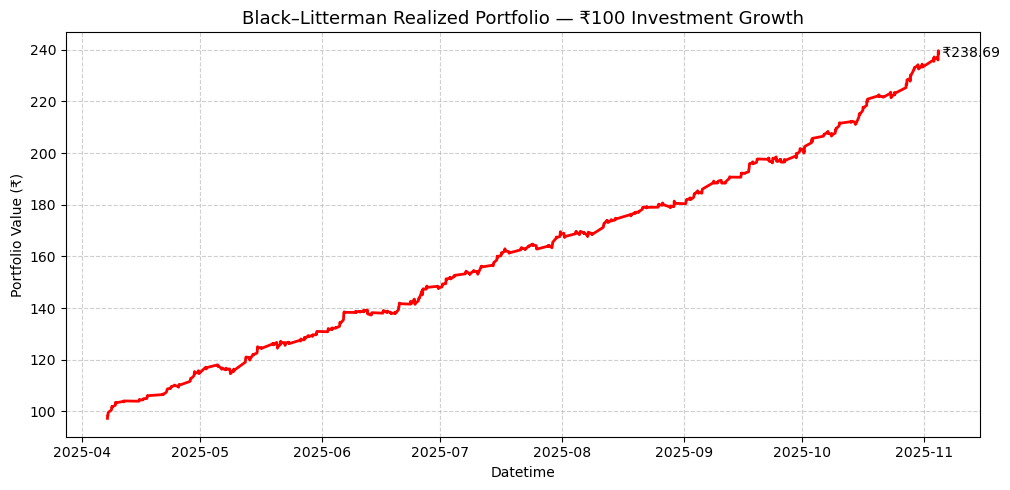

In [46]:
summary, weights_df, result_df = bl_front_simulation(
    predicted_data_folder=predicted_data_folder,
    ticker_to_basename=ticker_to_basename,
    simulate_investment=simulate_investment,
    apply_date="2025-04-06",
    withdraw_date="2025-11-06",
    k=10,
    rf=0.05 / 252,
    tau=0.05
)


In [ ]:
result_df

,Datetime,Realized_Portfolio_Value
0,2025-10-06 09:15:00,100.293656
1,2025-10-06 10:15:00,100.367768
2,2025-10-06 11:15:00,100.420755
3,2025-10-06 12:15:00,100.565349
4,2025-10-06 13:15:00,100.499133
...,...,...
116,2025-10-30 11:15:00,111.512315
117,2025-10-30 12:15:00,111.480572
118,2025-10-30 13:15:00,111.152183
119,2025-10-30 14:15:00,111.105787
